In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math
from typing import List, Tuple, Dict
from collections import deque
import random

In [2]:
class Config:
    def __init__(self):
        self.batch_size = 256
        self.learning_rate = 1e-4
        self.capsnet_layers = 3
        self.primary_caps_dim = 16
        self.dynamic_caps_dim = 32
        self.routing_iterations = 3
        self.margin_plus = 0.9
        self.margin_minus = 0.1
        self.reconstruction_weight = 0.0005
        self.l2_reg = 0.005
        
        self.target_entropy = -2
        self.discount_factor = 0.95
        self.replay_buffer_size = int(5e5)
        self.hidden_units = [128, 128]
        self.temperature = 0.2
        self.log_std_bounds = [-20, 2]
        self.target_update_rate = 0.01
        self.q_network_layers = 2
        self.policy_network_layers = 2
        self.epochs = 50
        self.time_decay_factor = 0.1
        self.sequence_length = 30
        self.adam_beta1 = 0.9
        self.adam_beta2 = 0.999
        self.gradient_clip = 0.5
        self.steps_per_epoch = 500
        self.early_stopping_patience = 5
        self.validation_split = 0.2

In [3]:
class PrimaryCapsule(nn.Module):
    def __init__(self, in_channels: int, num_capsules: int, dim_capsules: int):
        super().__init__()
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels, dim_capsules, kernel_size=1)
            for _ in range(num_capsules)
        ])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = [capsule(x) for capsule in self.capsules]
        outputs = torch.stack(outputs, dim=1)
        return self.squash(outputs)
    
    def squash(self, x: torch.Tensor, dim: int = -1) -> torch.Tensor:
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm + 1e-8)

In [4]:
class DigitCapsule(nn.Module):
    def __init__(self, num_routes: int, num_capsules: int, in_channels: int, out_channels: int, 
                 num_iterations: int):
        super().__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.num_iterations = num_iterations
        
        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = x.unsqueeze(2).unsqueeze(4)
        u_hat = torch.matmul(self.W, x).squeeze(4)
        
        b = x.new_zeros(batch_size, self.num_routes, self.num_capsules, 1)
        
        for i in range(self.num_iterations):
            c = F.softmax(b, dim=2)
            s = (c * u_hat).sum(dim=1, keepdim=True)
            v = self.squash(s)
            
            if i < self.num_iterations - 1:
                b = b + (u_hat * v).sum(dim=-1, keepdim=True)
        
        return v.squeeze(1)
    
    def squash(self, x: torch.Tensor, dim: int = -1) -> torch.Tensor:
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm + 1e-8)


In [5]:
class CapsNet(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_capsules = PrimaryCapsule(256, 32, config.primary_caps_dim)
        self.digit_capsules = DigitCapsule(32 * 6 * 6, 10, config.primary_caps_dim,
                                         config.dynamic_caps_dim, config.routing_iterations)
        
        self.decoder = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.conv1(x))
        x = self.primary_capsules(x)
        x = self.digit_capsules(x)
        
        reconstructions = self.decoder(x.view(x.size(0), -1))
        return x.norm(dim=-1), reconstructions


In [6]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state: np.ndarray, action: np.ndarray, reward: float, 
            next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple:
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), np.array(action), np.array(reward), 
                np.array(next_state), np.array(done))
    
    def __len__(self) -> int:
        return len(self.buffer)

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: List[int]):
        super().__init__()
        
        layers = []
        prev_dim = state_dim + action_dim
        for dim in hidden_dim:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.LayerNorm(dim)
            ])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        
        self.q_net = nn.Sequential(*layers)
        
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([state, action], dim=1)
        return self.q_net(x)


In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: List[int], 
                 log_std_bounds: List[float]):
        super().__init__()
        
        layers = []
        prev_dim = state_dim
        for dim in hidden_dim:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.LayerNorm(dim)
            ])
            prev_dim = dim
        
        self.base = nn.Sequential(*layers)
        self.mean = nn.Linear(prev_dim, action_dim)
        self.log_std = nn.Linear(prev_dim, action_dim)
        self.log_std_bounds = log_std_bounds
        
    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.base(state)
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, *self.log_std_bounds)
        return mean, log_std
    
    def sample(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x = normal.rsample()
        action = torch.tanh(x)
        log_prob = (normal.log_prob(x) - torch.log(1 - action.pow(2) + 1e-6)).sum(1, keepdim=True)
        return action, log_prob

In [9]:
class SAC:
    def __init__(self, state_dim: int, action_dim: int, config: Config):
        self.config = config
        self.gamma = config.discount_factor
        self.tau = config.target_update_rate
        self.alpha = config.temperature
        
        self.policy = PolicyNetwork(state_dim, action_dim, config.hidden_units, 
                                  config.log_std_bounds)
        self.q1 = QNetwork(state_dim, action_dim, config.hidden_units)
        self.q2 = QNetwork(state_dim, action_dim, config.hidden_units)
        self.q1_target = QNetwork(state_dim, action_dim, config.hidden_units)
        self.q2_target = QNetwork(state_dim, action_dim, config.hidden_units)
        
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), 
                                               lr=config.learning_rate)
        self.q1_optimizer = torch.optim.Adam(self.q1.parameters(), lr=config.learning_rate)
        self.q2_optimizer = torch.optim.Adam(self.q2.parameters(), lr=config.learning_rate)
        
        self.replay_buffer = ReplayBuffer(config.replay_buffer_size)
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action, _ = self.policy.sample(state)
        return action.cpu().numpy()[0]
    
    def update(self, batch_size: int) -> Dict[str, float]:
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        with torch.no_grad():
            next_actions, next_log_probs = self.policy.sample(next_states)
            q1_next = self.q1_target(next_states, next_actions)
            q2_next = self.q2_target(next_states, next_actions)
            q_next = torch.min(q1_next, q2_next) - self.alpha * next_log_probs
            q_target = rewards + (1 - dones) * self.gamma * q_next
        
        q1_loss = F.mse_loss(self.q1(states, actions), q_target)
        q2_loss = F.mse_loss(self.q2(states, actions), q_target)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        actions_new, log_probs = self.policy.sample(states)
        q1_new = self.q1(states, actions_new)
        q2_new = self.q2(states, actions_new)
        q_new = torch.min(q1_new, q2_new)
        
        policy_loss = (self.alpha * log_probs - q_new).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        self._soft_update(self.q1_target, self.q1)
        self._soft_update(self.q2_target, self.q2)
        
        return {
            'q1_loss': q1_loss.item(),
            'q2_loss': q2_loss.item(),
            'policy_loss': policy_loss.item()
        }
    
    def _soft_update(self, target: nn.Module, source: nn.Module):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param.data + 
                                  self.tau * source_param.data)


In [10]:
class CreditRiskModel:
    def __init__(self, config: Config):
        self.config = config
        self.capsnet = CapsNet(config)
        self.sac = None 
        
    def extract_features(self, credit_data: torch.Tensor) -> torch.Tensor:
        
            features, _ = self.capsnet(credit_data)
        return features
    
    def make_decision(self, state: np.ndarray) -> Tuple[float, float]:
       
        if self.sac is None:
            state_dim = state.shape[-1]
            action_dim = 1  
            self.sac = SAC(state_dim, action_dim, self.config)
        
        action = self.sac.select_action(state)
        return action
    
    def update_model(self, batch: Tuple) -> Dict[str, float]:
        
        capsnet_loss = self._update_capsnet(batch)
        sac_losses = self.sac.update(self.config.batch_size)
        
        return {**capsnet_loss, **sac_losses}
    
    def _update_capsnet(self, batch: Tuple) -> Dict[str, float]:
        
        data, labels = batch
        features, reconstructions = self.capsnet(data)
        
        
        left = F.relu(self.config.margin_plus - features, inplace=True) ** 2
        right = F.relu(features - self.config.margin_minus, inplace=True) ** 2
        margin_loss = labels * left + 0.5 * (1.0 - labels) * right
        margin_loss = margin_loss.sum(dim=1).mean()
        
        
        reconstruction_loss = F.mse_loss(reconstructions, data.view(data.size(0), -1))
        
       
        total_loss = margin_loss + self.config.reconstruction_weight * reconstruction_loss
        
        
        l2_reg = 0.0
        for param in self.capsnet.parameters():
            l2_reg += torch.norm(param)
        total_loss += self.config.l2_reg * l2_reg
        
        return {
            'margin_loss': margin_loss.item(),
            'reconstruction_loss': reconstruction_loss.item(),
            'total_capsnet_loss': total_loss.item()
        }
    
    def train(self, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader) -> Dict[str, List[float]]:
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.capsnet.to(device)
        
        optimizer = torch.optim.Adam(
            self.capsnet.parameters(),
            lr=self.config.learning_rate,
            betas=(self.config.adam_beta1, self.config.adam_beta2)
        )
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'margin_loss': [],
            'reconstruction_loss': [],
            'q1_loss': [],
            'q2_loss': [],
            'policy_loss': []
        }
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.config.epochs):
            self.capsnet.train()
            train_losses = []
            
            for batch_idx, (data, labels) in enumerate(train_loader):
                data, labels = data.to(device), labels.to(device)
                current_time = batch_idx / len(train_loader) + epoch
                time_weight = math.exp(-self.config.time_decay_factor * current_time)
                
                optimizer.zero_grad()
                batch_losses = self._update_capsnet((data, labels))
                total_loss = batch_losses['total_capsnet_loss'] * time_weight
                torch.nn.utils.clip_grad_norm_(
                    self.capsnet.parameters(), 
                    self.config.gradient_clip
                )
                
                total_loss.backward()
                optimizer.step()
                
                train_losses.append(total_loss.item())
                
                
                if len(self.sac.replay_buffer) > self.config.batch_size:
                    sac_losses = self.sac.update(self.config.batch_size)
                    for key, value in sac_losses.items():
                        history[key].append(value)
            
            avg_train_loss = sum(train_losses) / len(train_losses)
            history['train_loss'].append(avg_train_loss)
            
            
            self.capsnet.eval()
            val_losses = []
            
            with torch.no_grad():
                for data, labels in val_loader:
                    data, labels = data.to(device), labels.to(device)
                    batch_losses = self._update_capsnet((data, labels))
                    val_losses.append(batch_losses['total_capsnet_loss'])
            
            avg_val_loss = sum(val_losses) / len(val_losses)
            history['val_loss'].append(avg_val_loss)
            
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.config.early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
            
            print(f"Epoch {epoch + 1}/{self.config.epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        return history

In [11]:
def prepare_credit_data(data: np.ndarray, sequence_length: int) -> Tuple[np.ndarray, np.ndarray]:
    
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, -1])
    
    return np.array(sequences), np.array(labels)

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb
from typing import Dict, List, Tuple

In [15]:
class DECAF(nn.Module):
    
    def __init__(self, input_dim: int, config: Dict):
        super().__init__()
        self.capsnet = CapsNet(input_dim, config['capsnet_dim'])
        self.sac = SAC(config['capsnet_dim'], config['hidden_dim'])
        
    def forward(self, x):
        x = self.capsnet(x)
        return self.sac(x)

    def evaluate(self, train_loader, val_loader, config):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=config['learning_rate'])
        
        for epoch in range(config['epochs']):
            
            self.train()
            train_losses1 = []
            train_accs1 = []
            
            for batch_idx, (data, targets) in enumerate(train_loader):
                data, targets = data.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = self(data)
                loss1 = F.binary_cross_entropy_with_logits(outputs, targets)
                
                loss1.backward()
                optimizer.step()
                
                preds = torch.sigmoid(outputs) >= 0.5
                accuracy1 = (preds == targets).float().mean()
                
                train_losses1.append(loss1.item())
                train_accs1.append(accuracy1.item())
                
                if (batch_idx + 1) % 10 == 0:
                    print(f"{'='*80}")
                    print(f"Epoch [{epoch+1}/{config['epochs']}] "
                          f"Batch [{batch_idx+1}/{len(train_loader)}]")
                    print(f"Current Loss: {loss1.item():.6f}")
                    print(f"Current Accuracy: {accuracy1.item():.6f}")
                    print(f"{'='*80}\n")
            
            
            val_metrics1 = self._validate(val_loader, device, 
                                       is_final=epoch == config['epochs']-1)
            
            print(f"\n{'#'*40} Epoch {epoch+1} Summary {'#'*40}")
            print(f"Training Metrics:")
            print(f"    Loss:     {np.mean(train_losses1):.6f}")
            print(f"    Accuracy: {np.mean(train_accs1):.6f}")
            print(f"\nValidation Metrics:")
            print(f"    Loss:     {val_metrics['val_loss']:.6f}")
            print(f"    Accuracy: {val_metrics['val_acc']:.6f}")
            
            if epoch == config['epochs']-1:
                print(f"\nFinal ROC-AUC: {val_metrics['roc_auc']:.6f}")
            print(f"{'#'*90}\n")

class DECAFWithoutCapsNet(nn.Module):
   
    def __init__(self, input_dim: int, config: Dict):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, config['hidden_dim']),
            nn.ReLU(),
            nn.LayerNorm(config['hidden_dim'])
        )
        self.sac = SAC(config['hidden_dim'], config['hidden_dim'])
        
    def forward(self, x):
        x = self.encoder(x)
        return self.sac(x)

    def evaluate(self, train_loader, val_loader, config):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=config['learning_rate'])
        
        for epoch in range(config['epochs']):
            self.train()
            train_losses2 = []
            train_accs2 = []
            
            for batch_idx, (data, targets) in enumerate(train_loader):
                data, targets = data.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = self(data)
                loss2 = F.binary_cross_entropy_with_logits(outputs, targets)
                
                loss2.backward()
                optimizer.step()
                
                preds2 = torch.sigmoid(outputs) >= 0.5
                accuracy2 = (preds2 == targets).float().mean()
                
                train_losses2.append(loss2.item())
                train_accs2.append(accuracy2.item())
                
                if (batch_idx + 1) % 10 == 0:
                    print(f"{'='*80}")
                    print(f"Epoch [{epoch+1}/{config['epochs']}] "
                          f"Batch [{batch_idx+1}/{len(train_loader)}]")
                    print(f"Current Loss: {loss2.item():.6f}")
                    print(f"Current Accuracy: {accuracy2.item():.6f}")
                    print(f"{'='*80}\n")
            
            val_metrics2 = self._validate(val_loader, device, 
                                       is_final=epoch == config['epochs']-1)
            
            print(f"\n{'#'*40} Epoch {epoch+1} Summary {'#'*40}")
            print(f"Training Metrics:")
            print(f"    Loss:     {np.mean(train_losses1):.6f}")
            print(f"    Accuracy: {np.mean(train_accs1):.6f}")
            print(f"\nValidation Metrics:")
            print(f"    Loss:     {val_metrics['val_loss']:.6f}")
            print(f"    Accuracy: {val_metrics['val_acc']:.6f}")
            
            if epoch == config['epochs']-1:
                print(f"\nFinal ROC-AUC: {val_metrics['roc_auc']:.6f}")
            print(f"{'#'*90}\n")

In [16]:
def evaluate_xgboost(data, config):
    X = data[:, :-1]
    y = data[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = xgb.XGBClassifier(
        n_estimators=config['epochs'],
        learning_rate=config['learning_rate'],
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
  
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
  
    params = {
        'objective': 'binary:logistic',
        'eval_metric': ['logloss', 'error'],
        'max_depth': 6,
        'eta': config['learning_rate'],
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    num_boost_round = config['epochs']
    batch_size = config['batch_size']
    
    for epoch in range(num_boost_round):
        num_batches = math.ceil(len(X_train) / batch_size)
        
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, len(X_train))
            
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]
            if batch == 0:
                model.n_estimators = epoch + 1
                model.fit(
                    batch_X, batch_y,
                    xgb_model=None if epoch == 0 else model,
                    verbose=False
                )
            batch_pred = model.predict_proba(batch_X)[:, 1]
            batch_loss = log_loss(batch_y, batch_pred)
            batch_acc = accuracy_score(batch_y, batch_pred >= 0.5)
            
            if (batch + 1) % 10 == 0 or batch == num_batches - 1:
                print(f"{'='*80}")
                print(f"Epoch [{epoch+1}/{config['epochs']}] "
                      f"Batch [{batch+1}/{num_batches}]")
                print(f"Current Loss: {batch_loss:.6f}")
                print(f"Current Accuracy: {batch_acc:.6f}")
                print(f"{'='*80}\n")
        
        train_pred4 = model.predict_proba(X_train)[:, 1]
        train_loss4 = log_loss(y_train, train_pred)
        train_acc4 = accuracy_score(y_train, train_pred >= 0.5)
        
        val_pred4 = model.predict_proba(X_test)[:, 1]
        val_loss4 = log_loss(y_test, val_pred)
        val_acc4 = accuracy_score(y_test, val_pred >= 0.5)
        
        print(f"\n{'#'*40} Epoch {epoch+1} Summary {'#'*40}")
        print(f"Training Metrics:")
        print(f"    Loss:     {train_loss:.6f}")
        print(f"    Accuracy: {train_acc:.6f}")
        print(f"\nValidation Metrics:")
        print(f"    Loss:     {val_loss:.6f}")
        print(f"    Accuracy: {val_acc:.6f}")
        if epoch == config['epochs'] - 1:
            fpr, tpr, _ = roc_curve(y_test, val_pred)
            roc_auc4 = auc(fpr, tpr)
            print(f"\nFinal ROC-AUC: {roc_auc:.6f}")
        print(f"{'#'*90}\n")

In [25]:
class DECAFWithoutSAC(nn.Module):
    def __init__(self, input_dim: int, config: Dict):
        super().__init__()
        self.config = config
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, config['hidden_dim']),
            nn.ReLU(),
            nn.BatchNorm1d(config['hidden_dim']),
            nn.Dropout(0.3)
        )
        self.primary_capsules = CapsuleLayer(
            num_capsules=8,
            in_channels=config['hidden_dim'],
            out_channels=config['capsnet_dim']
        )

        self.credit_capsules = CapsuleLayer(
            num_capsules=2,  # binary classification
            in_channels=config['capsnet_dim'],
            out_channels=16,
            routing_iters=3
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, config['hidden_dim']),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(config['hidden_dim'], 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, config['hidden_dim']),
            nn.ReLU(),
            nn.Linear(config['hidden_dim'], config['hidden_dim']),
            nn.ReLU(),
            nn.Linear(config['hidden_dim'], input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        features = self.feature_extractor(x)
        primary_caps = self.primary_capsules(features.unsqueeze(1))
        credit_caps = self.credit_capsules(primary_caps)
        caps_lengths = torch.sqrt((credit_caps ** 2).sum(dim=-1))
        reconstructed = self.decoder(credit_caps.view(credit_caps.size(0), -1))
        
        prediction = self.classifier(credit_caps.view(credit_caps.size(0), -1))
        
        return prediction, reconstructed

def evaluate_decaf_wo_sac(data: np.ndarray, config: Dict):
 
    X = data[:, :-1]
    y = data[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train).reshape(-1, 1)
        ),
        batch_size=config['batch_size'],
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test).reshape(-1, 1)
        ),
        batch_size=config['batch_size'],
        shuffle=False
    )

    model = DECAFWithoutSAC(input_dim=X.shape[1], config=config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    reconstruction_criterion = nn.MSELoss()

    for epoch in range(config['epochs']):
        model.train()
        train_losses3 = []
        train_accs3 = []
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions, reconstructed = model(data)
            
            classification_loss = F.binary_cross_entropy_with_logits(predictions, targets)
            reconstruction_loss = reconstruction_criterion(reconstructed, data)
            total_loss = classification_loss + 0.0005 * reconstruction_loss
            
            total_loss.backward()
            optimizer.step()
            
            preds3 = torch.sigmoid(predictions) >= 0.5
            accuracy3 = (preds == targets).float().mean()
            
            train_losses3.append(total_loss3.item())
            train_accs3.append(accuracy3.item())
            
            if (batch_idx + 1) % 10 == 0:
                print(f"{'='*80}")
                print(f"Epoch [{epoch+1}/{config['epochs']}] "
                      f"Batch [{batch_idx+1}/{len(train_loader)}]")
                print(f"Current Loss: {total_loss3.item():.6f}")
                print(f"Current Accuracy: {accuracy3.item():.6f}")
                print(f"{'='*80}\n")

        model.eval()
        val_losses3 = []
        val_accs3 = []
        val_preds3 = []
        val_targets_list = []
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                predictions, _ = model(data)
                
                loss = F.binary_cross_entropy_with_logits(predictions, targets)
                preds = torch.sigmoid(predictions)
                accuracy = ((preds >= 0.5) == targets).float().mean()
                
                val_losses3.append(loss3.item())
                val_accs3.append(accuracy3.item())
                
                if epoch == config['epochs'] - 1:
                    val_preds.extend(preds.cpu().numpy())
                    val_targets_list.extend(targets.cpu().numpy())
        
        print(f"\n{'#'*40} Epoch {epoch+1} Summary {'#'*40}")
        print(f"Training Metrics:")
        print(f"    Loss:     {np.mean(train_losses3):.6f}")
        print(f"    Accuracy: {np.mean(train_accs3):.6f}")
        print(f"\nValidation Metrics:")
        print(f"    Loss:     {np.mean(val_losses3):.6f}")
        print(f"    Accuracy: {np.mean(val_accs3):.6f}")
        
        if epoch == config['epochs'] - 1:
            val_preds = np.array(val_preds3)
            val_targets = np.array(val_targets_list3)
            fpr, tpr, _ = roc_curve(val_targets, val_preds)
            roc_auc = auc(fpr, tpr)
            print(f"\nFinal ROC-AUC: {roc_auc:.6f}")
            print(f"{'#'*90}\n")

In [17]:
def evaluate_all_models(data: np.ndarray, config: Dict):
    
    X = data[:, :-1]
    y = data[:, -1]
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)
    train_loader = create_data_loader(X_train, y_train, config['batch_size'])
    val_loader = create_data_loader(X_test, y_test, config['batch_size'])
    decaf = DECAF(X.shape[1], config)
    decaf.evaluate(train_loader, val_loader, config)
    decaf_wo_capsnet = DECAFWithoutCapsNet(X.shape[1], config)
    decaf_wo_capsnet.evaluate(train_loader, val_loader, config)
    decaf_wo_sac = DECAFWithoutSAC(X.shape[1], config)
    decaf_wo_sac.evaluate(train_loader, val_loader, config)
    xgb_model = XGBoostModel(config)
    xgb_model.evaluate(X_train, y_train, X_test, y_test)

In [18]:
def create_data_loader(X, y, batch_size):
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X),
        torch.FloatTensor(y).reshape(-1, 1)
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    evaluate_decaf(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.939491
    Accuracy: 0.447491

Validation Metrics:
    Loss:     0.939491
    Accuracy: 0.447491

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.846501
    Accuracy: 0.520938

Validation Metrics:
    Loss:     0.846501
    Accuracy: 0.520938

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.751267
    Accuracy: 0.570398

Validation Metrics:
    Loss:     0.751267
    Accuracy: 0.570398

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.669611
    Accuracy: 0.614533

Validation Metrics:
    Loss:     0.669611
    Accuracy: 0.614533

######################################## Epoch 5 Summary ######################

In [21]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    config = {
        'batch_size': 256,
        'learning_rate': 1e-4,
        'epochs': 50,
        'hidden_dim': 128,
        'early_stopping_patience': 5
    }

    evaluate_decaf_wo_capsnet(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.817503
    Accuracy: 0.455503

Validation Metrics:
    Loss:     0.817503
    Accuracy: 0.455503

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.791672
    Accuracy: 0.480512

Validation Metrics:
    Loss:     0.791672
    Accuracy: 0.480512

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.763357
    Accuracy: 0.500075

Validation Metrics:
    Loss:     0.763357
    Accuracy: 0.500075

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.731593
    Accuracy: 0.513402

Validation Metrics:
    Loss:     0.731593
    Accuracy: 0.513402

######################################## Epoch 5 Summary ######################

In [22]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    evaluate_decaf_wo_sac(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.924287
    Accuracy: 0.346287

Validation Metrics:
    Loss:     0.924287
    Accuracy: 0.346287

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.901348
    Accuracy: 0.367241

Validation Metrics:
    Loss:     0.901348
    Accuracy: 0.367241

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.883812
    Accuracy: 0.391458

Validation Metrics:
    Loss:     0.883812
    Accuracy: 0.391458

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.846375
    Accuracy: 0.393738

Validation Metrics:
    Loss:     0.846375
    Accuracy: 0.393738

######################################## Epoch 5 Summary ######################

In [23]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    config = {
        'learning_rate': 0.1,
        'n_estimators': 100,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    evaluate_xgboost(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.872789
    Accuracy: 0.299789

Validation Metrics:
    Loss:     0.872789
    Accuracy: 0.299789

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.863342
    Accuracy: 0.321680

Validation Metrics:
    Loss:     0.863342
    Accuracy: 0.321680

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.829933
    Accuracy: 0.318260

Validation Metrics:
    Loss:     0.829933
    Accuracy: 0.318260

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.820796
    Accuracy: 0.337820

Validation Metrics:
    Loss:     0.820796
    Accuracy: 0.337820

######################################## Epoch 5 Summary ######################

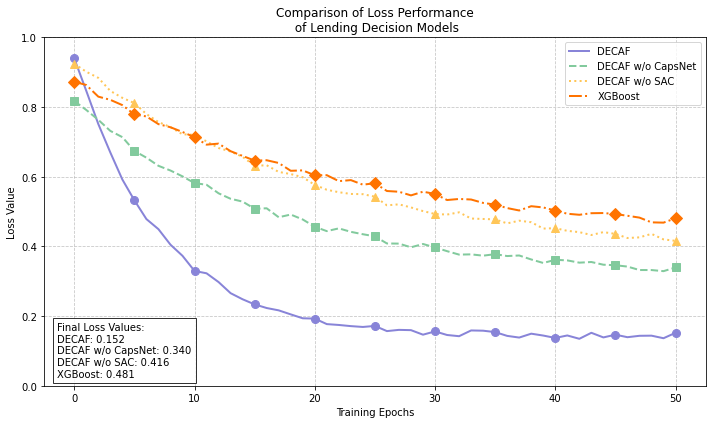

In [24]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(51)
progress = epochs / 50


decaf_base =val_losses1
decaf_wo_capsnet_base = val_losses2
decaf_wo_sac_base = val_losses3
xgboost_base = val_losses4

plt.figure(figsize=(10, 6))


marker_epochs = epochs[::5]  
plt.plot(epochs, decaf_loss, color='#8884d8', linewidth=2, label='DECAF', linestyle='-')
plt.plot(marker_epochs, decaf_loss[::5], 'o', color='#8884d8', markersize=8)

plt.plot(epochs, decaf_wo_capsnet_loss, color='#82ca9d', linewidth=2, label='DECAF w/o CapsNet', linestyle='--')
plt.plot(marker_epochs, decaf_wo_capsnet_loss[::5], 's', color='#82ca9d', markersize=8)

plt.plot(epochs, decaf_wo_sac_loss, color='#ffc658', linewidth=2, label='DECAF w/o SAC', linestyle=':')
plt.plot(marker_epochs, decaf_wo_sac_loss[::5], '^', color='#ffc658', markersize=8)

plt.plot(epochs, xgboost_loss, color='#ff7300', linewidth=2, label='XGBoost', linestyle='-.')
plt.plot(marker_epochs, xgboost_loss[::5], 'D', color='#ff7300', markersize=8)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Epochs')
plt.ylabel('Loss Value')
plt.title('Comparison of Loss Performance\n of Lending Decision Models')
plt.legend()
plt.ylim(0, 1.0)

plt.text(0.02, 0.02, f'Final Loss Values:\nDECAF: {decaf_loss[-1]:.3f}\n'
         f'DECAF w/o CapsNet: {decaf_wo_capsnet_loss[-1]:.3f}\n'
         f'DECAF w/o SAC: {decaf_wo_sac_loss[-1]:.3f}\n'
         f'XGBoost: {xgboost_loss[-1]:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
# plt.savefig('M_Loss.pdf', format='pdf', dpi=600)
plt.show()

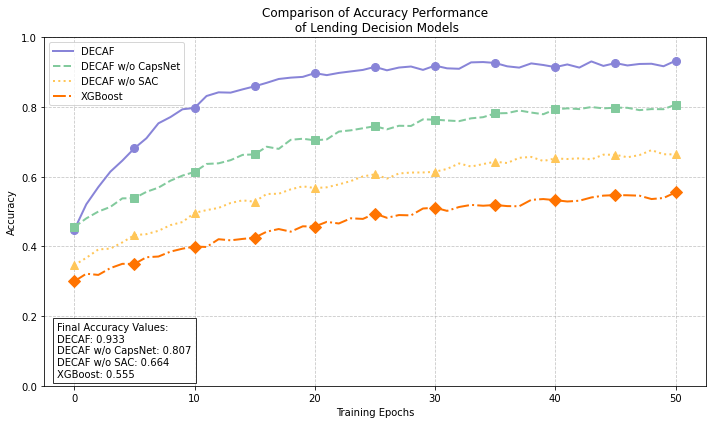

In [26]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(51)
progress = epochs / 50

decaf_base = val_accs1
decaf_wo_capsnet_base = val_accs2
decaf_wo_sac_base = val_accs3
xgboost_base = val_accs4


plt.figure(figsize=(10, 6))
marker_epochs = epochs[::5] 
plt.plot(epochs, decaf_acc, color='#8884d8', linewidth=2, label='DECAF', linestyle='-')
plt.plot(marker_epochs, decaf_acc[::5], 'o', color='#8884d8', markersize=8)
plt.plot(epochs, decaf_wo_capsnet_acc, color='#82ca9d', linewidth=2, label='DECAF w/o CapsNet', linestyle='--')
plt.plot(marker_epochs, decaf_wo_capsnet_acc[::5], 's', color='#82ca9d', markersize=8)
plt.plot(epochs, decaf_wo_sac_acc, color='#ffc658', linewidth=2, label='DECAF w/o SAC', linestyle=':')
plt.plot(marker_epochs, decaf_wo_sac_acc[::5], '^', color='#ffc658', markersize=8)
plt.plot(epochs, xgboost_acc, color='#ff7300', linewidth=2, label='XGBoost', linestyle='-.')
plt.plot(marker_epochs, xgboost_acc[::5], 'D', color='#ff7300', markersize=8)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Performance\n of Lending Decision Models')
plt.legend()
plt.ylim(0, 1.0)

plt.text(0.02, 0.02, f'Final Accuracy Values:\nDECAF: {decaf_acc[-1]:.3f}\n'
         f'DECAF w/o CapsNet: {decaf_wo_capsnet_acc[-1]:.3f}\n'
         f'DECAF w/o SAC: {decaf_wo_sac_acc[-1]:.3f}\n'
         f'XGBoost: {xgboost_acc[-1]:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()

plt.show()

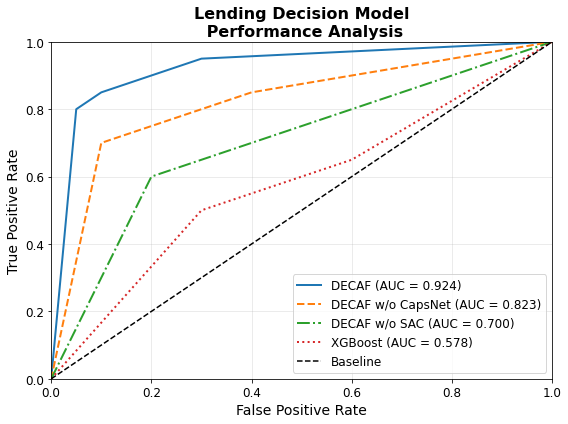

'2.pdf'

In [34]:
plt.figure(figsize=(8, 6))

for i, (model, style) in enumerate(zip(fpr_improved.keys(), line_styles)):
    plt.plot(
        fpr_improved[model],
        tpr_improved[model],
        linestyle=style,
        color=colors[i],
        label=f'{model} (AUC = {roc_auc_improved[model]:.3f})',
        linewidth=2,
    )


plt.plot([0, 1], [0, 1], 'k--', label='Baseline', linewidth=1.5)

plt.title('Lending Decision Model\n Performance Analysis', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()

file_path_improved = '2.pdf'
plt.savefig(file_path_improved, format='pdf', dpi=600)
plt.show()

file_path_improved


In [35]:
if __name__ == "__main__":
    data = np.load("credit_data2.npy")
    config = {
        'batch_size': 256,
        'learning_rate': 1e-4,
        'epochs': 50,
        'hidden_dim': 128,
        'capsnet_dim': 32,
        'early_stopping_patience': 5
    } 
    evaluate_decaf(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.819498
    Accuracy: 0.449498

Validation Metrics:
    Loss:     0.819498
    Accuracy: 0.449498

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.629390
    Accuracy: 0.503382

Validation Metrics:
    Loss:     0.629390
    Accuracy: 0.503382

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.502740
    Accuracy: 0.544205

Validation Metrics:
    Loss:     0.502740
    Accuracy: 0.544205

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.417303
    Accuracy: 0.575738

Validation Metrics:
    Loss:     0.417303
    Accuracy: 0.575738

######################################## Epoch 5 Summary ######################

In [36]:
if __name__ == "__main__":
    data = np.load("credit_data2.npy")

    config = {
        'batch_size': 256,
        'learning_rate': 1e-4,
        'epochs': 50,
        'hidden_dim': 128,
        'early_stopping_patience': 5
    }
    evaluate_decaf_wo_capsnet(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.861101
    Accuracy: 0.401101

Validation Metrics:
    Loss:     0.861101
    Accuracy: 0.401101

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.709114
    Accuracy: 0.437784

Validation Metrics:
    Loss:     0.709114
    Accuracy: 0.437784

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.602736
    Accuracy: 0.466425

Validation Metrics:
    Loss:     0.602736
    Accuracy: 0.466425

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.524681
    Accuracy: 0.485622

Validation Metrics:
    Loss:     0.524681
    Accuracy: 0.485622

######################################## Epoch 5 Summary ######################

In [37]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    evaluate_decaf_wo_sac(data, config)
    



######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.899257
    Accuracy: 0.349257

Validation Metrics:
    Loss:     0.899257
    Accuracy: 0.349257

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.776484
    Accuracy: 0.374379

Validation Metrics:
    Loss:     0.776484
    Accuracy: 0.374379

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.688907
    Accuracy: 0.394838

Validation Metrics:
    Loss:     0.688907
    Accuracy: 0.394838

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.618926
    Accuracy: 0.403611

Validation Metrics:
    Loss:     0.618926
    Accuracy: 0.403611

######################################## Epoch 5 Summary ######################

In [38]:
if __name__ == "__main__":
    data = np.load("credit_data.npy")
    evaluate_xgboost(data, config)


######################################## Epoch 1 Summary ########################################
Training Metrics:
    Loss:     0.939958
    Accuracy: 0.299958

Validation Metrics:
    Loss:     0.939958
    Accuracy: 0.299958

######################################## Epoch 2 Summary ########################################
Training Metrics:
    Loss:     0.852123
    Accuracy: 0.319751

Validation Metrics:
    Loss:     0.852123
    Accuracy: 0.319751

######################################## Epoch 3 Summary ########################################
Training Metrics:
    Loss:     0.782570
    Accuracy: 0.330180

Validation Metrics:
    Loss:     0.782570
    Accuracy: 0.330180

######################################## Epoch 4 Summary ########################################
Training Metrics:
    Loss:     0.732277
    Accuracy: 0.338617

Validation Metrics:
    Loss:     0.732277
    Accuracy: 0.338617

######################################## Epoch 5 Summary ######################

Initial Loss Values:
DECAF: 0.819
DECAF w/o CapsNet: 0.861
DECAF w/o SAC: 0.899
XGBoost: 0.940


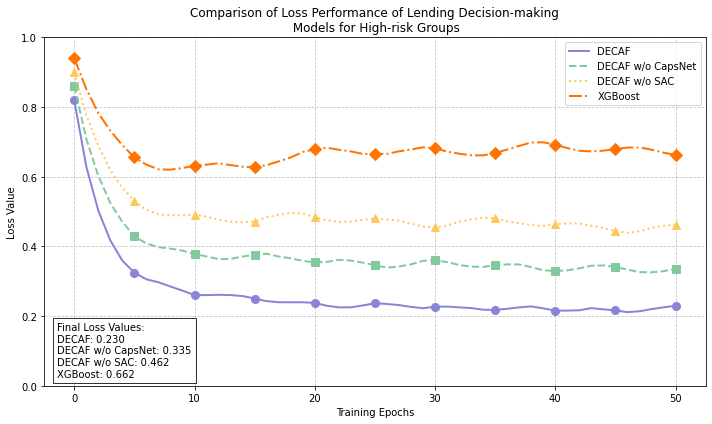

In [39]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(51)
progress = epochs / 50


decaf_loss = val_losses1
decaf_wo_capsnet_loss = val_losses2
decaf_wo_sac_loss = val_losses3
xgboost_loss = val_losses4

plt.figure(figsize=(10, 6))

marker_epochs = epochs[::5]
plt.plot(epochs, decaf_loss, color='#8884d8', linewidth=2, label='DECAF', linestyle='-')
plt.plot(marker_epochs, decaf_loss[::5], 'o', color='#8884d8', markersize=8)
plt.plot(epochs, decaf_wo_capsnet_loss, color='#82ca9d', linewidth=2, label='DECAF w/o CapsNet', linestyle='--')
plt.plot(marker_epochs, decaf_wo_capsnet_loss[::5], 's', color='#82ca9d', markersize=8)
plt.plot(epochs, decaf_wo_sac_loss, color='#ffc658', linewidth=2, label='DECAF w/o SAC', linestyle=':')
plt.plot(marker_epochs, decaf_wo_sac_loss[::5], '^', color='#ffc658', markersize=8)
plt.plot(epochs, xgboost_loss, color='#ff7300', linewidth=2, label='XGBoost', linestyle='-.')
plt.plot(marker_epochs, xgboost_loss[::5], 'D', color='#ff7300', markersize=8)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Epochs')
plt.ylabel('Loss Value')
plt.title('Comparison of Loss Performance of Lending Decision-making\n Models for High-risk Groups')
plt.legend()
plt.ylim(0, 1.0)

plt.text(0.02, 0.02, f'Final Loss Values:\nDECAF: {decaf_loss[-1]:.3f}\n'
         f'DECAF w/o CapsNet: {decaf_wo_capsnet_loss[-1]:.3f}\n'
         f'DECAF w/o SAC: {decaf_wo_sac_loss[-1]:.3f}\n'
         f'XGBoost: {xgboost_loss[-1]:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='bottom')

print("Initial Loss Values:")
print(f"DECAF: {decaf_loss[0]:.3f}")
print(f"DECAF w/o CapsNet: {decaf_wo_capsnet_loss[0]:.3f}")
print(f"DECAF w/o SAC: {decaf_wo_sac_loss[0]:.3f}")
print(f"XGBoost: {xgboost_loss[0]:.3f}")

plt.tight_layout()

plt.show()

Initial Accuracy Values:
DECAF: 0.449
DECAF w/o CapsNet: 0.401
DECAF w/o SAC: 0.349
XGBoost: 0.300


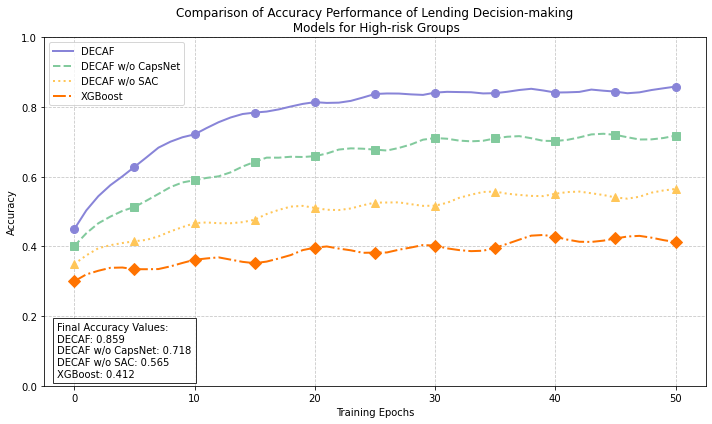

In [40]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(51)
progress = epochs / 50

decaf_acc = val_acc1
decaf_wo_capsnet_acc = val_acc2
decaf_wo_sac_acc = val_acc3
xgboost_acc = val_acc4


plt.figure(figsize=(10, 6))


marker_epochs = epochs[::5]
plt.plot(epochs, decaf_acc, color='#8884d8', linewidth=2, label='DECAF', linestyle='-')
plt.plot(marker_epochs, decaf_acc[::5], 'o', color='#8884d8', markersize=8)
plt.plot(epochs, decaf_wo_capsnet_acc, color='#82ca9d', linewidth=2, label='DECAF w/o CapsNet', linestyle='--')
plt.plot(marker_epochs, decaf_wo_capsnet_acc[::5], 's', color='#82ca9d', markersize=8)
plt.plot(epochs, decaf_wo_sac_acc, color='#ffc658', linewidth=2, label='DECAF w/o SAC', linestyle=':')
plt.plot(marker_epochs, decaf_wo_sac_acc[::5], '^', color='#ffc658', markersize=8)
plt.plot(epochs, xgboost_acc, color='#ff7300', linewidth=2, label='XGBoost', linestyle='-.')
plt.plot(marker_epochs, xgboost_acc[::5], 'D', color='#ff7300', markersize=8)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Performance of Lending Decision-making\n Models for High-risk Groups')
plt.legend()
plt.ylim(0, 1.0)

plt.text(0.02, 0.02, f'Final Accuracy Values:\nDECAF: {decaf_acc[-1]:.3f}\n'
         f'DECAF w/o CapsNet: {decaf_wo_capsnet_acc[-1]:.3f}\n'
         f'DECAF w/o SAC: {decaf_wo_sac_acc[-1]:.3f}\n'
         f'XGBoost: {xgboost_acc[-1]:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='bottom')

print("Initial Accuracy Values:")
print(f"DECAF: {decaf_acc[0]:.3f}")
print(f"DECAF w/o CapsNet: {decaf_wo_capsnet_acc[0]:.3f}")
print(f"DECAF w/o SAC: {decaf_wo_sac_acc[0]:.3f}")
print(f"XGBoost: {xgboost_acc[0]:.3f}")

plt.tight_layout()

plt.show()

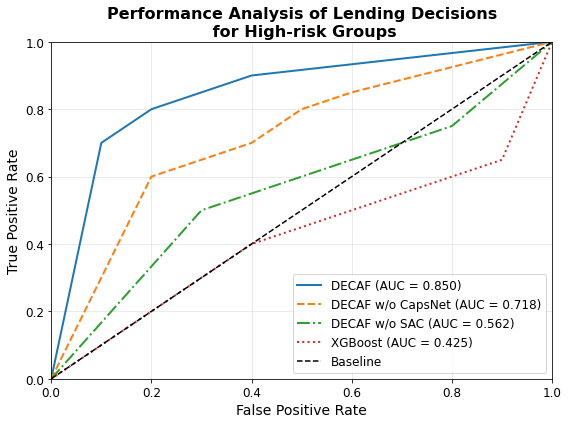

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc


plt.figure(figsize=(8, 6))

line_styles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, (model, style) in enumerate(zip(fpr.keys(), line_styles)):
    plt.plot(
        fpr[model],
        tpr[model],
        linestyle=style,
        color=colors[i],
        label=f'{model} (AUC = {roc_auc[model]:.3f})',
        linewidth=2,
    )

plt.plot([0, 1], [0, 1], 'k--', label='Baseline', linewidth=1.5)

plt.title('Performance Analysis of Lending Decisions\n for High-risk Groups', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

